# LAB: (quasi-) Newton methods


The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
and compare your implementation with the BFGS and L-BFGS solvers in scipy

You will need to knowledge on **line search methods** and **conjugate gradient** in particular you should reuse the notebooks presented during the lectures.



In [3]:
# Change here using YOUR first and last names
fn1 = "stephane"
ln1 = "gaiffas"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_gaiffas_stephane_and_gramfort_alexandre.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll have work only with the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

Let us now make an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now I can call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


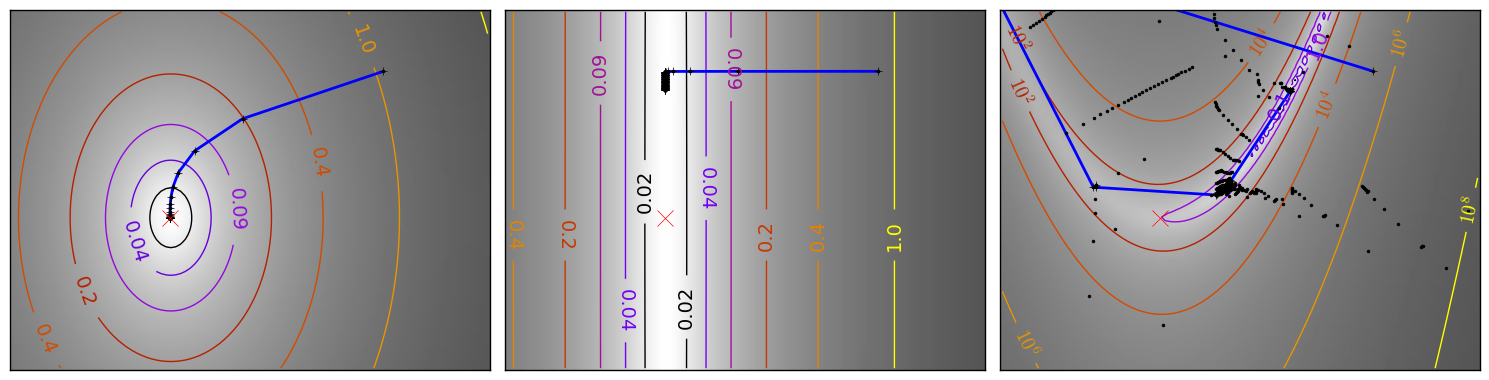

In [6]:
test_solver(gradient_descent)

# Part 2: Implement Newton method

You now need to implement Newton method using either `linalg.solve` or `sparse.linalg.cg` solve the linear system at each iteration. You need to implement both versions.

You're expected to comment in a few lines what you see.

In [7]:
import scipy.linalg as linalg
from numpy.linalg import inv

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        ####################################
        # Compute here the search direction
        # d = ...
        ####################################
        d = linalg.solve(-f_hessian(x),grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        # x = ...
        ##################################
        
        x = x + step*d
      
    

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_norm(grad): 3.9843
iter: 4, f: 0.088137, l_inf_norm(grad): 6.14586
iter: 5, f: 0.0414804, l_inf_norm(grad): 3.93321
iter: 6, f: 0.0162138, l_inf_norm(grad): 2.7976
iter: 7, f: 0.00446914, l_inf_norm(grad): 1.29953
iter: 8, f: 0.000705202, l_inf_norm(grad): 0.668389
iter: 9, f: 3.34966e-05, l_inf_norm(grad): 0.121298
iter: 10, f: 1.24866e-07, l_inf_norm(grad): 0.00982241
iter: 11, f: 2.01025e-12, l_inf_norm(grad): 3.05844e-05
iter: 12, f: 5.2958e-22, l_inf_norm(grad): 6.41073e-10


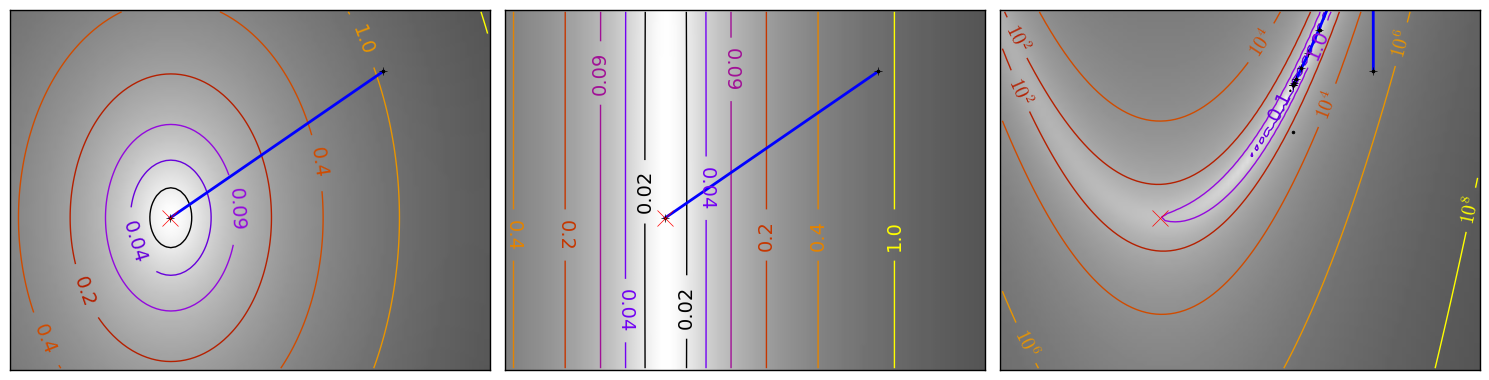

In [8]:
test_solver(newton)

#### Your comments here

# Part 2: Implement DFP algorithm

You now need to implement the DFP algorithm.

In [75]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = - B.dot(grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x = x + step * d
        ##################################
        
        new_grad = f_grad(x)
        new_f = f(x)
        
        #########################################################
        # Update the inverse Hessian approximation
        s = step * d
        y = new_grad - grad_x
        
        s = s[:, None]
        y = y[:, None]
        B = B + (s.dot(s.T)) / (s.T.dot(y)) - (B.dot(y.dot(y.T.dot(B)))) / (y.T.dot(B.dot(y)))
        #########################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            pass
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' % (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0214911, l_inf_norm(grad): 0.114753
iter: 3, f: 0.00899657, l_inf_norm(grad): 0.069501
iter: 4, f: 0.00023476, l_inf_norm(grad): 0.0175216
iter: 5, f: 1.76801e-05, l_inf_norm(grad): 0.00465113
iter: 6, f: 3.20353e-08, l_inf_norm(grad): 0.000140183
iter: 7, f: 1.32183e-10, l_inf_norm(grad): 8.99094e-06
iter: 8, f: 8.82459e-15, l_inf_norm(grad): 1.04309e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000138677, l_inf_norm(grad): 0.000270594
iter: 4, f: 1.92681e-07, l_inf_norm(grad): 0.000503909
iter: 5, f: 1.4273e-07, l_inf_norm(grad): 0.000433799
iter: 6, f: 3.512e-14, l_inf_norm(grad): 1.6706e-08

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.56575, l_inf_norm(grad): 24.138
iter: 3, f: 7.34339, l_inf_norm(grad): 4.87789
iter: 4, f: 7.29892, l_inf_norm(grad): 8.4

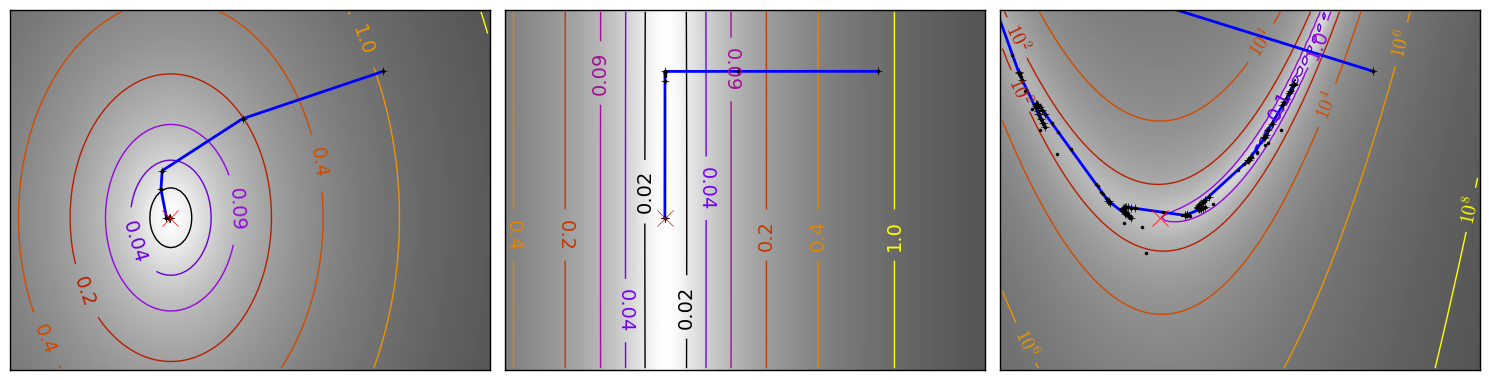

In [76]:
test_solver(dfp)

#### Your comments here

# Part 3: Implement BFGS algorithm

You now need to implement the BFGS algorithm.

In [77]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        # d = ...
        ####################################
        d = linalg.solve(-H,grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################    
        # Compute here the new value of x
        # x = ...
        ##################################
        x_new = x + step*d
        
        #####################################################
        # Update the Hessian approximation   
        # H = ...
        #####################################################
        #s = step*d
        s = x_new - x
        y = H*s
        #y = f_grad(x_new)- f_grad(x)
        
        H = H + y.dot(y.T)/ y.T.dot(s) - (H.dot(s).dot(s.T)*H)/(s.T.dot(H).dot(s))
        x = x_new
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0522931, l_inf_norm(grad): 0.162853
iter: 3, f: 0.020076, l_inf_norm(grad): 0.110187
iter: 4, f: 0.00874399, l_inf_norm(grad): 0.0745522
iter: 5, f: 0.00395127, l_inf_norm(grad): 0.050442
iter: 6, f: 0.00180287, l_inf_norm(grad): 0.0341291
iter: 7, f: 0.000824643, l_inf_norm(grad): 0.0230917
iter: 8, f: 0.000377432, l_inf_norm(grad): 0.0156239
iter: 9, f: 0.000172774, l_inf_norm(grad): 0.0105711
iter: 10, f: 7.90929e-05, l_inf_norm(grad): 0.00715241
iter: 11, f: 3.62076e-05, l_inf_norm(grad): 0.00483932
iter: 12, f: 1.65754e-05, l_inf_norm(grad): 0.00327429
iter: 13, f: 7.588e-06, l_inf_norm(grad): 0.00221538
iter: 14, f: 3.47369e-06, l_inf_norm(grad): 0.00149893
iter: 15, f: 1.59021e-06, l_inf_norm(grad): 0.00101417
iter: 16, f: 7.2798e-07, l_inf_norm(grad): 0.00068619
iter: 17, f: 3.3326e-07, l_inf_norm(grad): 0.000464276
iter: 18, f: 1.52562e-07, l_inf_norm(grad): 0.000314129
iter: 19, f: 6.98411

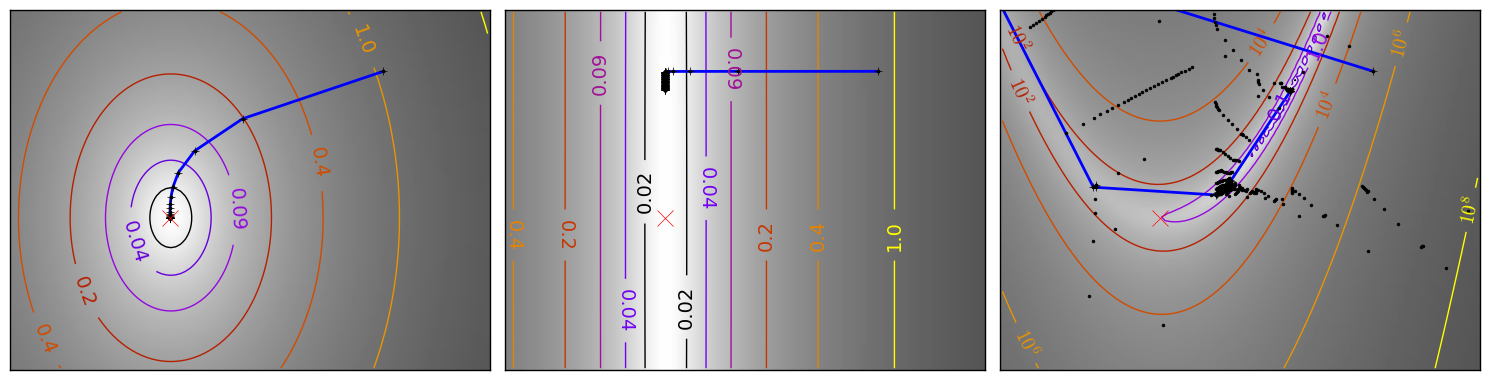

In [78]:
test_solver(bfgs)

#### Your comments here

# Part 4: Do the same now with scipy implementation of BFGS and L-BFGS

In [9]:
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b

# TODO
?fmin_bfgs

#### Your comments here